In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler



In [3]:
from simplestELM.ELM import ELMRegressor

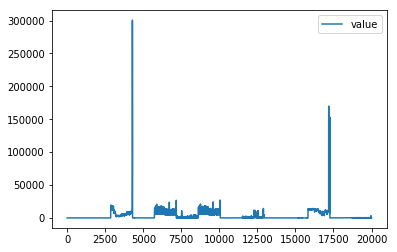

In [4]:
import glob
import os
import pandas as pd
from matplotlib import pyplot as plt
path=r'C:\Users\anmol narang\Desktop\extreme_learning\S5_Yahoo_anomaly_detection_labeled\ydata-labeled-time-series-anomalies-v1_0\A1Benchmark'
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

concatenated_df=concatenated_df[:50000].drop(['timestamp','is_anomaly'],axis=1)

concatenated_df[:20000].plot()
plt.show()


In [5]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df


raw_seq=concatenated_df['value'].values

X = timeseries_to_supervised(raw_seq)###### CHANGE THIS ACCORDING TO YOUR DATA !!!!!!!!! PASS YOUR DATAFRAME WITH ONE COLUMN ONLY!!!

X.columns=['X','y']

X=X.values




test_maes_dictionary = dict()

plt.style.use('ggplot')
sns.set_context("talk")
np.random.seed(0)

In [6]:
## DATA PREPROCESSING

def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

train, test = X[0:-2000], X[-2000:]
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]


scaler, train_scaled, test_scaled = scale(train, test)

In [7]:
X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
## ELM TRAINING
MAE_TRAIN_MINS = []
MAE_TEST_MINS = []

for M in range(1, 20, 1):
    MAES_TRAIN = []
    MAES_TEST = []
    # print "Training with %s neurons..."%M
    for i in range(10):
        ELM = ELMRegressor(M)
        ELM.fit(X, y)
        
        
def forecast_elm(model, X):
	
	yhat = model.predict(X)
	return yhat[0]

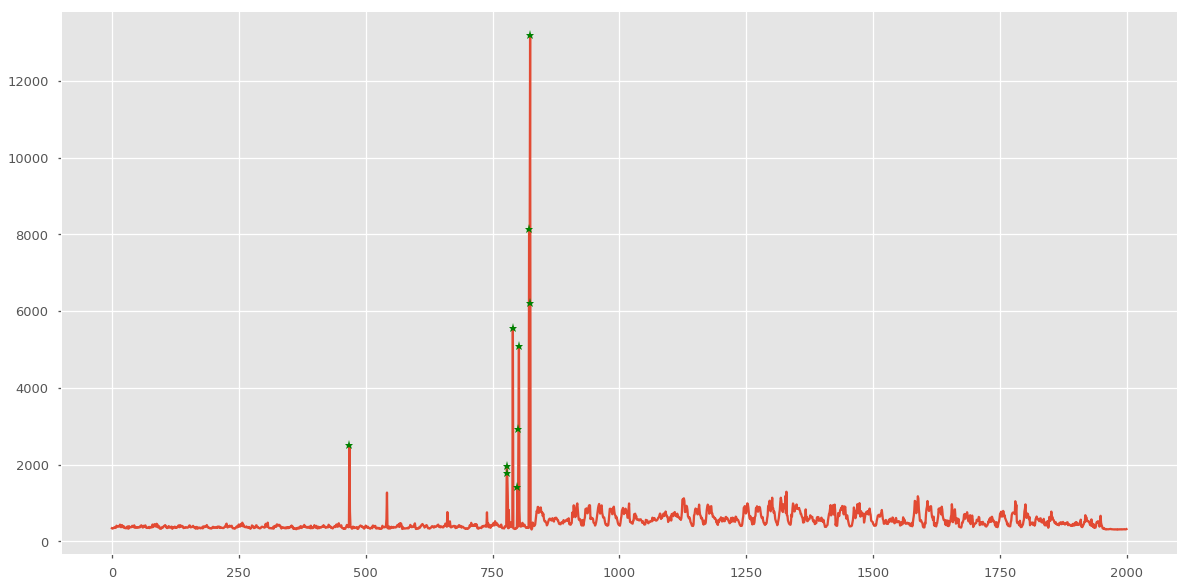

In [8]:
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_elm(ELM, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	
	# store forecast
	predictions.append(yhat)
	

pred=pd.Series((predictions)).astype(int)  
pred=pred.loc[pred>0]  



elements = np.array(pred)


mean = np.mean(elements, axis=0)
sd = np.std(elements, axis=0)

pred_outliers=pred.loc[pred<mean-2*sd]
pred_outliers2=pred.loc[pred>mean+2*sd]

outliers=pd.concat([pred_outliers,pred_outliers2],axis=0)

plt.figure(figsize=[20,10])
plt.plot(pred)
plt.plot(outliers,'g*')
